In [1]:
import os.path as osp, os
os.environ["CUDA_VISIBLE_DEVICES"] = ''
import torch, numpy as np, polars as pl
from data.graphdataset import ThermoMLDataset, ramirez, ThermoMLpara
from train.train import create_model
from train.model_deg import calc_deg
from data.graph import from_InChI
from train.parametrisation import MAPE, rhovp_data
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

False

In [3]:
ra_loader = ramirez("./data/ramirez2022")
ra_para = {}
for graph in ra_loader:
    inchi, para = graph.InChI, graph.para.view(-1, 3).round(decimals=2)
    ra_para[inchi] = para.tolist()[0]

In [4]:
tml_loader = ThermoMLpara("./data/thermoml")
tml_para = {}
for graph in tml_loader:
    inchi, para = graph.InChI, graph.para.view(-1, 3).round(decimals=2)
    tml_para[inchi] = para.tolist()[0]

In [5]:
path = osp.join("data", "thermoml")
testloader = ThermoMLDataset(path)
device = torch.device("cpu")

In [6]:
from configs.default import get_config
config = get_config()

In [7]:
config.propagation_depth=4
config.hidden_dim=128
config.num_mlp_layers=2
config.pre_layers=1
config.post_layers=3

In [8]:
model_dtype = torch.float64

In [9]:
# Create and initialize the network.
deg = calc_deg("ramirez", './')
model = create_model(config, deg).to(device, model_dtype)

In [10]:
# Set up checkpointing of the model.
ckp_path = "./train/checkpoints/model1-2_21e6.pth"
if osp.exists(ckp_path):
    checkpoint = torch.load(ckp_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"model checkpoint step {checkpoint['step']}")
    del checkpoint


model checkpoint step 2210000


In [ ]:
model_para = {}
model_array = {}
model.eval()
with torch.no_grad():
    for graphs in testloader:
        graphs.x = graphs.x.to(model_dtype)
        graphs.edge_attr = graphs.edge_attr.to(model_dtype)
        graphs.edge_index = graphs.edge_index.to(torch.int64)

        graphs = graphs.to(device)
        parameters = model(graphs)
        params = parameters.squeeze().to(torch.float64).numpy()
        rho = graphs.rho.view(-1, 5).to(torch.float64).numpy()
        vp = graphs.vp.view(-1, 5).to(torch.float64).numpy()
        mden_array, mvp_array = MAPE(params, rho, vp, False)
        mden, mvp = mden_array.mean(), mvp_array.mean()
        parameters = parameters.tolist()[0]
        model_para[graphs.InChI] = (parameters, mden, mvp)
        model_array[graphs.InChI] = (mden_array, mvp_array)

In [ ]:
for inchi in ra_para:
    if inchi in model_para:
        ml, mden, mvp = model_para[inchi]
        ra = np.array(ra_para[inchi])
        ml = np.array(ml)
        mape = np.abs(ra - ml) / ra * 100
        
        if (mden > 50 / 100 or mvp > 50 / 100):
            print(inchi)
            print(f"###########---{mape}---##########")
            print(f"###########---{mden*100, mvp*100}---##########")
            for row in zip(ra, ml):
                print(row)

In [ ]:
data = {"inchis":[],"mden":[],"mvp":[]}
for inchi in model_para:
    data['inchis'].append(inchi)
    data['mden'].append(model_para[inchi][1])
    data['mvp'].append(model_para[inchi][2])

In [ ]:
modelx = pl.DataFrame(data)

In [ ]:
modelx.write_csv('model2.csv')

In [ ]:
import pickle
with open("./data/thermoml/processed/para3.pkl", "wb") as file:
        # A new file will be created
        pickle.dump(model_para, file)

In [ ]:
import pickle
with open("./data/thermoml/raw/para3_fitted.pkl", "wb") as file:
        # A new file will be created
        pickle.dump(model_para, file)

In [ ]:
n_rho_vp = 0
n_rho = 0
n_vp = 0
ntrain = 0
ntrain_rhovp = 0
size_vp = 0
size_rho = 0
for graph in testloader:
    if torch.all(graph.rho == torch.zeros_like(graph.rho)):
        n_vp += 1
    elif torch.all(graph.vp == torch.zeros_like(graph.vp)):
        n_rho += 1
    else:
        n_rho_vp += 1
        if graph.InChI not in ra_para:
            ntrain_rhovp += 1 
    
    if graph.InChI not in ra_para:
        ntrain += 1


In [ ]:
n_rho_vp, n_rho, n_vp, ntrain, ntrain_rhovp

In [ ]:
import pickle, numpy as np
with open("./data/thermoml/raw/para3_fitted.pkl", "rb") as file:
        # A new file will be created
        para_fitted = pickle.load( file)

In [ ]:
len(para_fitted)

In [ ]:
n = 0
nra = 0
for inchi in para_fitted:
    ml, mden, mvp = para_fitted[inchi]
    if ( (mden > 0.05) or (mvp > 0.05) ):
            print(inchi)
            print(f"###########---{mden, mvp}---##########")
            print(ml)
            n +=1
    if inchi in ra_para:
        nra += 1
print(f"number of test set left: {n}")
print(f"number of train set: {len(para_fitted) - n}")
print(f"number of val set: {nra}")

In [ ]:
inchi = "InChI=1S/H2O/h1H2"
ml, mden, mvp = model_para[inchi]
mden_array, mvp_array = model_array[inchi]
ra = ra_para[inchi]
fit, mden_fit, mvp_fit = para_fitted[inchi]
for row in zip(ra, ml, fit):
    print(row)

print(mden, mvp, mden_fit, mvp_fit)

In [ ]:
with torch.no_grad(): 
    graphs = from_InChI(inchi, with_hydrogen=True)
    graphs.x = graphs.x.to(model_dtype)
    graphs.edge_attr = graphs.edge_attr.to(model_dtype)
    graphs.edge_index = graphs.edge_index.to(torch.int64)

    graphs = graphs.to(device)
    parameters = model(graphs)
    params = parameters.squeeze().to(torch.float64).detach().numpy()
params

In [ ]:
for gh in testloader:
    if gh.InChI == inchi:
        break

In [ ]:
gh

In [92]:
def plotdata(inchi, modelname="Model 1"):
    def pltline(x, y):
        return plt.plot(x, y, linewidth=0.5)

    def pltscatter(x, y):
        return plt.scatter(x, y, marker="x", c="black", s=10)

    def plterr(x, y, m):
        tb = 0
        for i, mape in enumerate(np.round(m, decimals=1)):
            ta = x[i]
            if (mape > 1) & (ta - tb > 15):
                tb = ta
                plt.text(x[i], y[i], f"{mape} %", ha="right", va="top", fontsize=4)

    model.eval()
    with torch.no_grad():
        for graphs in testloader:
            if inchi == graphs.InChI:
                break
        graphs.x = graphs.x.to(model_dtype)
        graphs.edge_attr = graphs.edge_attr.to(model_dtype)
        graphs.edge_index = graphs.edge_index.to(torch.int64)

        graphs = graphs.to(device)
        parameters = model(graphs)
        params = parameters.squeeze().to(torch.float64).numpy()
        rho = graphs.rho.view(-1, 5).to(torch.float64).numpy()
        vp = graphs.vp.view(-1, 5).to(torch.float64).numpy()
        pred_den, pred_vp = rhovp_data(params, rho, vp)
        params = np.asarray(ra_para[inchi])
        ra_den, ra_vp = rhovp_data(params, rho, vp)

        idx_vp = (pred_vp != 0) & (ra_vp != 0)
        vp = vp[idx_vp]
        ra_vp = ra_vp[idx_vp]
        pred_vp = pred_vp[idx_vp]

        idx = np.argsort(vp[:, 0], 0)
        x = vp[idx, 0]
        y = vp[idx, -1] / 100000
        pltscatter(x, y)

        y = pred_vp[idx] / 100000
        pltline(x, y)
        mvp_model = 100 * np.abs(vp[idx, -1] - pred_vp[idx]) / vp[idx, -1]
        plterr(x, y*1.5, mvp_model)

        y = ra_vp[idx] / 100000
        pltline(x, y)
        mvp_ra = 100 * np.abs(vp[idx, -1] - ra_vp[idx]) / vp[idx, -1]
        plterr(x, y*1.5, mvp_ra)

        # Customize the plot appearance
        pltcustom(modelname, mvp_model, mvp_ra, 'log', "Pressão de vapor (Bar)")

        # Save the plot as a high-quality image file
        plt.savefig("images/vp.png", dpi=300)
        plt.show()

        idx_p = abs(rho[:, 1] - 101325) < 10000
        rho = rho[idx_p]
        pred_den = pred_den[idx_p]
        ra_den = ra_den[idx_p]
        idx = np.argsort(rho[:, 0], 0)

        x = rho[idx, 0]
        y = rho[idx, -1]
        pltscatter(x, y)

        y = pred_den[idx]
        pltline(x, y)
        mden_model = 100 * np.abs(rho[idx, -1] - pred_den[idx]) / rho[idx, -1]
        plterr(x, y, mden_model)

        y = ra_den[idx]
        pltline(x, y)
        mden_ra = 100 * np.abs(rho[idx, -1] - ra_den[idx]) / rho[idx, -1]
        plterr(x, y, mden_ra)

        # Customize the plot appearance
        pltcustom(modelname, mden_model, mden_ra, "linear", "Densidade (kg / m³)")
        plt.savefig("images/den.png", dpi=300)
        plt.show()


def pltcustom(modelname, m_model, m_ra, scale='linear', ylabel = ""):
    plt.xlabel("T (K)")
    plt.ylabel(ylabel)
    plt.title("")
    plt.legend(
        [
            "ThermoML",
            modelname + f" ({m_model.mean().round(decimals=2)} %)",
            f"Ramírez-Vélez et al. ({m_ra.mean().round(decimals=2)} %)",
        ]
    )
    plt.grid(False)
    plt.yscale(scale)

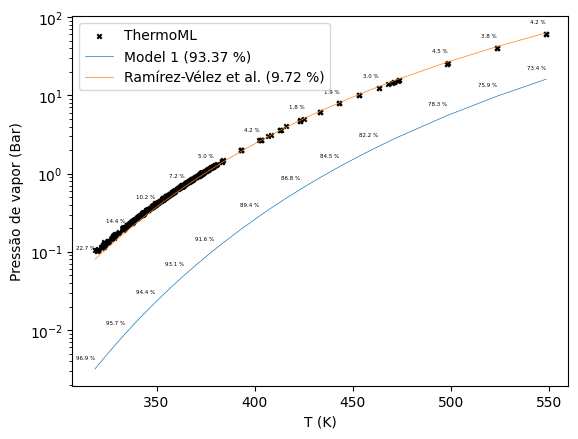

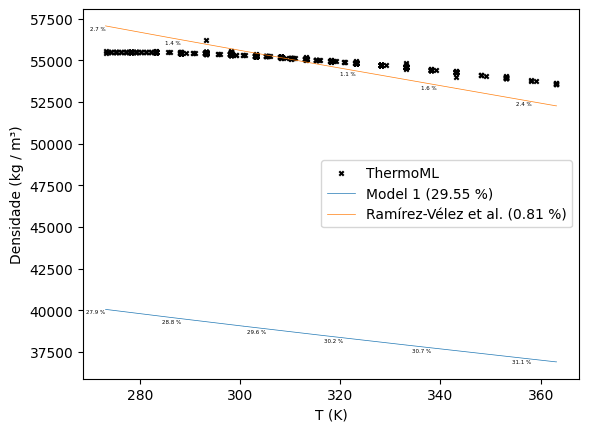

In [93]:
inchi = "InChI=1S/H2O/h1H2"
plotdata(inchi)